## Data 608 Homework 4: Enterococcus Levels in the Hudson River

#### Judd Anderman  
#### October 22, 2017

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
# from bokeh.charts import Bar, Histogram, TimeSeries, show
from bokeh.layouts import gridplot, row, column
from bokeh.models import Jitter, Range1d, FixedTicker, FuncTickFormatter
# from bokeh.io import output_notebook
from datetime import datetime, timedelta
sns.set(style="ticks")
%matplotlib inline

Import and clean enterococcus levels data

In [2]:
url = ''.join(['https://raw.githubusercontent.com/charleyferrari/CUNY_DATA608/',
               'master/lecture4/Data/riverkeeper_data_2013.csv'])
df = pd.read_csv(url)

In [3]:
print(list(df))
df.describe()

['Site', 'Date', 'EnteroCount', 'FourDayRainTotal', 'SampleCount']


,FourDayRainTotal,SampleCount
count,3397.000000,3397.000000
mean,0.568001,56.886370
std,1.000387,41.588476
min,0.000000,27.000000
25%,0.000000,37.000000
50%,0.200000,42.000000
75%,0.700000,50.000000
max,8.500000,187.000000


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
print(pd.unique(df['EnteroCount'].str.extract('(.*\D.*)', expand=False)))
df['EnteroCount'].str.replace('>|<', '')
df['EnteroCount'] = pd.to_numeric(df['EnteroCount'].str.replace('>|<', ''), downcast='integer')

[nan '>2420' '<1' '<10' '>24196']


In [5]:
df.describe()

,EnteroCount,FourDayRainTotal,SampleCount
count,3397.000000,3397.000000,3397.000000
mean,387.747719,0.568001,56.886370
std,2046.114024,1.000387,41.588476
min,0.000000,0.000000,27.000000
25%,10.000000,0.000000,37.000000
50%,18.000000,0.200000,42.000000
75%,85.000000,0.700000,50.000000
max,24196.000000,8.500000,187.000000


#### Question 1: Best and worst places to swim in the Hudson

In [6]:
def geo_mean(x):
    val = 1
    for e in x:
        val = val * float(e)
    return (np.power(val, 1.0 / len(x)))

Cleanest and dirtiest sites by simple average of EnteroCount observations

In [7]:
clean = df.groupby('Site')['EnteroCount'].agg(
    {'NumSamples': 'count', 'AvgEntero': 'mean'}).sort_values('AvgEntero').iloc[0:5]
clean['Class'] = 'Cleanest'
dirty = df.groupby('Site')['EnteroCount'].agg(
    {'NumSamples': 'count', 'AvgEntero': 'mean'}).sort_values('AvgEntero', ascending=False).iloc[0:5]
dirty['Class'] = 'Dirtiest'
subset = clean.append(dirty).reset_index()
subset = subset.sort_values('AvgEntero', ascending=True)
subset

,Site,AvgEntero,NumSamples,Class
0,Poughkeepsie Drinking Water Intake,8.342105,38,Cleanest
1,Croton Point Beach,15.458333,48,Cleanest
2,Stony Point mid-channel,17.340909,44,Cleanest
3,Little Stony Point,17.526316,38,Cleanest
4,Poughkeepsie Launch Ramp,17.675676,37,Cleanest
9,Upper Sparkill Creek,1296.072727,165,Dirtiest
8,Saw Mill River,1455.760000,50,Dirtiest
7,Tarrytown Marina,2205.666667,27,Dirtiest
6,Newtown Creek- Metropolitan Ave. Bridge,2953.684211,57,Dirtiest
5,Gowanus Canal,4206.837838,37,Dirtiest


Cleanest and dirtiest sites by geometric mean of EnteroCount observations

In [8]:
geo = df.groupby('Site')['EnteroCount'].apply(lambda x: geo_mean(x))
geo = pd.DataFrame(geo).reset_index()
geo.columns = ['Site', 'GeoMean']
clean = geo.sort_values('GeoMean').iloc[0:5]
dirty = geo.sort_values('GeoMean', ascending=False).iloc[0:5]
clean['Class'] = 'Cleanest'
dirty['Class'] = 'Dirtiest'
geo = clean.append(dirty)
geo = geo.sort_values('GeoMean', ascending=True).reset_index(drop=True)
geo

,Site,GeoMean,Class
0,Catskill Creek- First Bridge,0.000000,Cleanest
1,Norrie Point mid-channel,3.909624,Cleanest
2,Poughkeepsie Drinking Water Intake,4.381236,Cleanest
3,Port Ewen Drinking Water Intake,5.257241,Cleanest
4,Tivoli Landing,6.926002,Cleanest
5,Newtown Creek- Metropolitan Ave. Bridge,147.728997,Dirtiest
6,Mohawk River at Waterford,169.718920,Dirtiest
7,Gowanus Canal,181.330620,Dirtiest
8,Upper Sparkill Creek,inf,Dirtiest
9,Piermont Pier,inf,Dirtiest


In [9]:
df.sort_values(['Site', 'Date'])
subset = subset.merge(df, how='inner', on='Site')

In [10]:
sites = subset[['Site', 'Class']].drop_duplicates().reset_index(drop=True)

In [11]:
colors = []
for ix, row in sites.iterrows():
    if row['Class'] == 'Cleanest':
        colors.append(sns.color_palette("Blues", 5)[ix])
    else: 
        colors.append(sns.color_palette("Greens", 5)[ix-5])

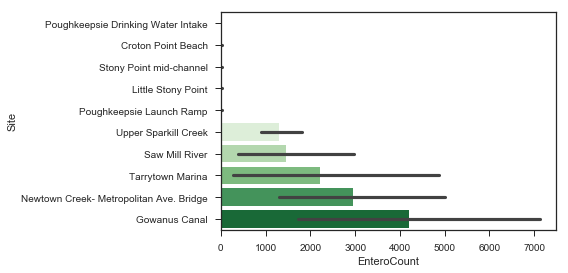

In [12]:
sns.barplot(x='EnteroCount', 
            y='Site', 
            palette=colors, 
            data=subset)

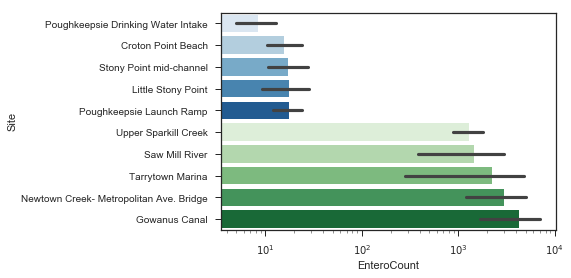

In [13]:
p2 = sns.barplot(x='EnteroCount', 
                 y='Site',
                 palette=colors, 
                 data=subset)
p2.set_xscale('log')

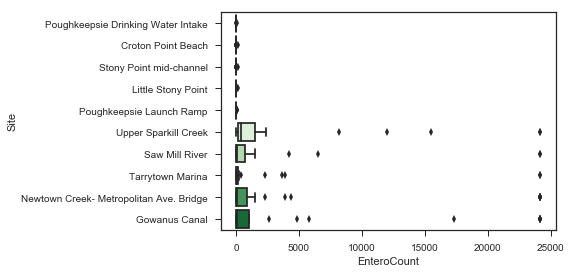

In [14]:
sns.boxplot(x='EnteroCount', y='Site', palette=colors, data=subset)

[(0, 2500)]

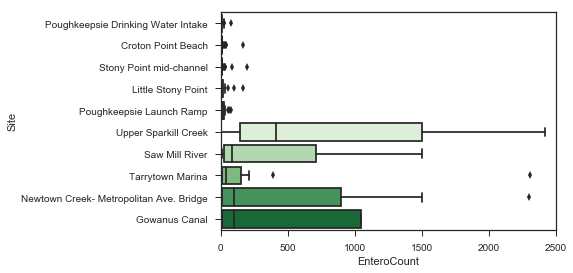

In [15]:
p4 = sns.boxplot(x='EnteroCount', y='Site', palette=colors, data=subset)
p4.set(xlim=(0, 2500))

In [16]:
output_notebook()

Loading BokehJS ...

In [17]:
avg = subset[['Site','AvgEntero']].drop_duplicates().reset_index(drop=True)

In [18]:
# bokeh.charts deprecated
# bkh_plt1 = Bar(subset, label='Site', values='EnteroCount', agg='mean',
#                title='Average Enterococcus Count across Cleanest and Dirtiest Sites',
#                legend=False, y_mapper_type='log')

bkh_plt1 = figure(x_range = sorted(avg['Site'].tolist()),
                  y_axis_type='log', y_range=(10**-1, 10**4))
bkh_plt1.vbar(source = avg, x='Site', top='AvgEntero', bottom = 10**-1, width = 0.8)
bkh_plt1.xaxis.major_label_orientation = pi/2
bkh_plt1.yaxis.axis_label = "Average Enterococcus count"
show(bkh_plt1)

Cleanest sites by average quantity of Enterococcus cells per 100 mL

In [19]:
for site in sites.loc[sites['Class'] == 'Cleanest']['Site']:
    print(site)

Poughkeepsie Drinking Water Intake
Croton Point Beach
Stony Point mid-channel
Little Stony Point
Poughkeepsie Launch Ramp


In [20]:
right_cut = max(subset.loc[subset['Site'].isin(
    sites.loc[sites['Class'] == 'Cleanest']['Site'])]['EnteroCount'])

hist_clean = []

# bokeh.charts deprecated
# for i, val in enumerate(sites.loc[sites['Class'] == 'Cleanest']['Site']):
#     h = Histogram(subset.loc[subset['Site'] == val], title = val,
#                values='EnteroCount', bins=25)
#     h.xaxis.axis_label = 'Enterococcus cell count/100 mL'
#     h.yaxis.axis_label = 'Count'
#     h.x_range = Range1d(0, right_cut)
#     hist_clean.append(h)

for i, val in enumerate(sites.loc[sites['Class'] == 'Cleanest']['Site']):
    hist, edges = np.histogram(
        subset.loc[subset['Site'] == val]['EnteroCount'],
        bins=50, density=True)
    h = figure(title = val)
    h.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="#036564", line_color="#033649")
    h.x_range = Range1d(0, right_cut)
    hist_clean.append(h)

show(gridplot(hist_clean[0:5], ncols=1, plot_height = 150, plot_width = 800))

Dirtiest sites by average quantity of Enterococcus cells per 100 mL

In [95]:
right_cut = max(subset.loc[subset['Site'].isin(sites.loc[sites['Class'] == 'Dirtiest']['Site'])]['EnteroCount'])

hist_dirty = []

# bokeh.charts deprecated
# for i, val in enumerate(sites.loc[sites['Class'] == 'Dirtiest']['Site']):
#     h = Histogram(subset.loc[subset['Site'] == val], title = val,
#                values='EnteroCount', bins=25)
#     h.xaxis.axis_label = 'Enterococcus cell count/100 mL'
#     h.yaxis.axis_label = 'Count'
#     h.x_range = Range1d(0, right_cut)
#     hist_dirty.append(h)

for i, val in enumerate(sites.loc[sites['Class'] == 'Dirtiest']['Site']):
    hist, edges = np.histogram(
        subset.loc[subset['Site'] == val]['EnteroCount'],
       bins=50, density=True)
    h = figure(title = val)
    h.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="#036564", line_color="#033649")
    h.x_range = Range1d(0, right_cut)
    hist_dirty.append(h)

show(gridplot(hist_dirty[0:5], ncols=1, plot_height = 150, plot_width = 800))

#### Question 2: Frequency of water quality testing

In [21]:
for site in sites.loc[sites['Class'] == 'Dirtiest']['Site']:
    print(site)

Upper Sparkill Creek
Saw Mill River
Tarrytown Marina
Newtown Creek- Metropolitan Ave. Bridge
Gowanus Canal


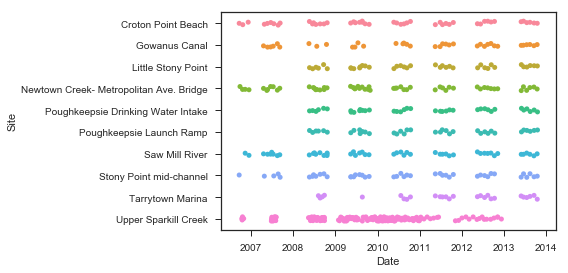

In [22]:
sns.stripplot(x='Date', y='Site', data=subset, jitter=True, 
              order = sorted(pd.unique(subset['Site'])))

In [23]:
# bokeh.charts deprecated
# bkh_plt2 = TimeSeries(data=subset, 
#                       x='Date',
#                       y='Site',
#                       title='Enterococcus sampling frequency by site',
#                       builder_type='point',
#                       plot_width=800)
# bkh_plt2.x_range = Range1d(min(subset['Date']) - timedelta(days=90), 
#                            max(subset['Date']) + timedelta(days=90))
# bkh_plt2.yaxis.major_label_orientation = "horizontal"

# add numeric coded values by site to use jitter in dot plot
subset['Site'] = pd.Categorical(subset['Site'])
subset['SiteCode'] = subset['Site'].cat.codes

lbls = subset[['Site', 'SiteCode']].reset_index(drop=True).set_index(
    ['SiteCode'])['Site'].to_dict()


bkh_plt2 = figure(plot_width=700, 
                  x_axis_type="datetime")#, 
                  #y_range=sites['Site'].tolist())
# bkh_plt2.circle(x='Date', y='Site', source=subset)
bkh_plt2.circle(x='Date', 
                y={'field': 'SiteCode', 'transform': Jitter(width=0.1)}, 
                source=subset)
bkh_plt2.y_range = Range1d(10, -1)
bkh_plt2.yaxis.ticker = FixedTicker(ticks=range(10))
bkh_plt2.yaxis.formatter = FuncTickFormatter(code="""
    var labels = %s;
    return labels[tick];
""" % lbls)
show(bkh_plt2)

#### Quesiton 3: Examining the relationship between Enterococcus counts and recent rain fall

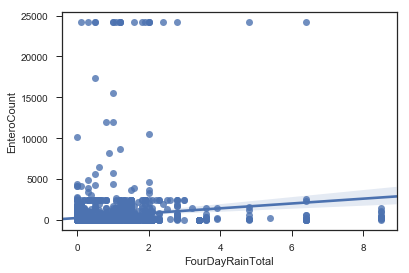

In [24]:
sns.regplot(x='FourDayRainTotal', y='EnteroCount', data=df)

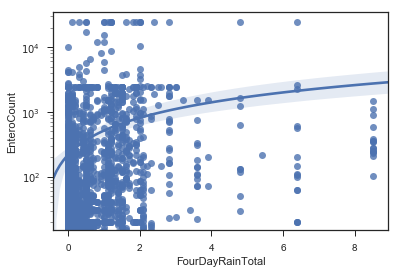

In [25]:
p5 = sns.regplot(x='FourDayRainTotal', y='EnteroCount', data=df)
p5.set_yscale('log')

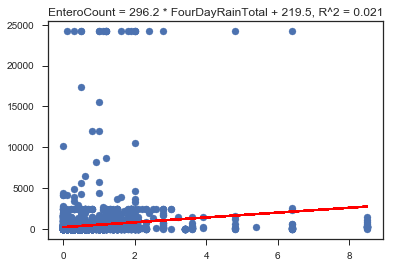

In [26]:
def lin_func(x, m, b):
    return m * x + b

def lin_regress(data):
    coef = sp.optimize.curve_fit(
        lin_func, 
        data['FourDayRainTotal'],
        data['EnteroCount'])[0]

    if (coef[1] >= 0):
        eq = 'EnteroCount = {:.1f} * FourDayRainTotal + {:.1f}'.format(
            coef[0], coef[1]
        )
    else:
        eq = 'EnteroCount = {:.1f} * FourDayRainTotal - {:.1f}'.format(
            coef[0], -coef[1]
    )
    return([coef, eq])

coef, eq = lin_regress(df)

fig, ax = plt.subplots()
ax.scatter(x=df['FourDayRainTotal'], y=df['EnteroCount'])
ax.plot(df['FourDayRainTotal'], lin_func(df['FourDayRainTotal'], *coef), 'r-')
r_sq = np.corrcoef(df['FourDayRainTotal'], df['EnteroCount'])[0, 1]**2
txt = eq + ', R^2 = {:.3f}'.format(r_sq)
ax.set_title(txt)

In [27]:
pval = sp.stats.linregress(df['FourDayRainTotal'], df['EnteroCount']).pvalue
pval

2.2010889600131478e-17

Re-run linear regression with outlier EnteroCount and FourDayRainTotal observations (i.e., < 95th percentile for each variable) removed from dataset

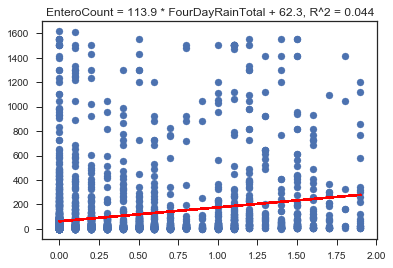

In [28]:
new_df = df.loc[(df['EnteroCount'] < np.percentile(df['EnteroCount'], 95)) &
                (df['FourDayRainTotal'] < np.percentile(df['FourDayRainTotal'], 95))]

coef, eq = lin_regress(new_df)

fig, ax = plt.subplots()
ax.scatter(x=new_df['FourDayRainTotal'], y=new_df['EnteroCount'])
ax.plot(new_df['FourDayRainTotal'], lin_func(new_df['FourDayRainTotal'], *coef), 'r-')
r_sq = np.corrcoef(new_df['FourDayRainTotal'], new_df['EnteroCount'])[0, 1]**2
txt = eq + ', R^2 = {:.3f}'.format(r_sq)
ax.set_title(txt)

In [29]:
pval = sp.stats.linregress(new_df['FourDayRainTotal'], new_df['EnteroCount']).pvalue
pval

4.9585514720304692e-32

In [30]:
len(pd.unique(df["Site"]))

75

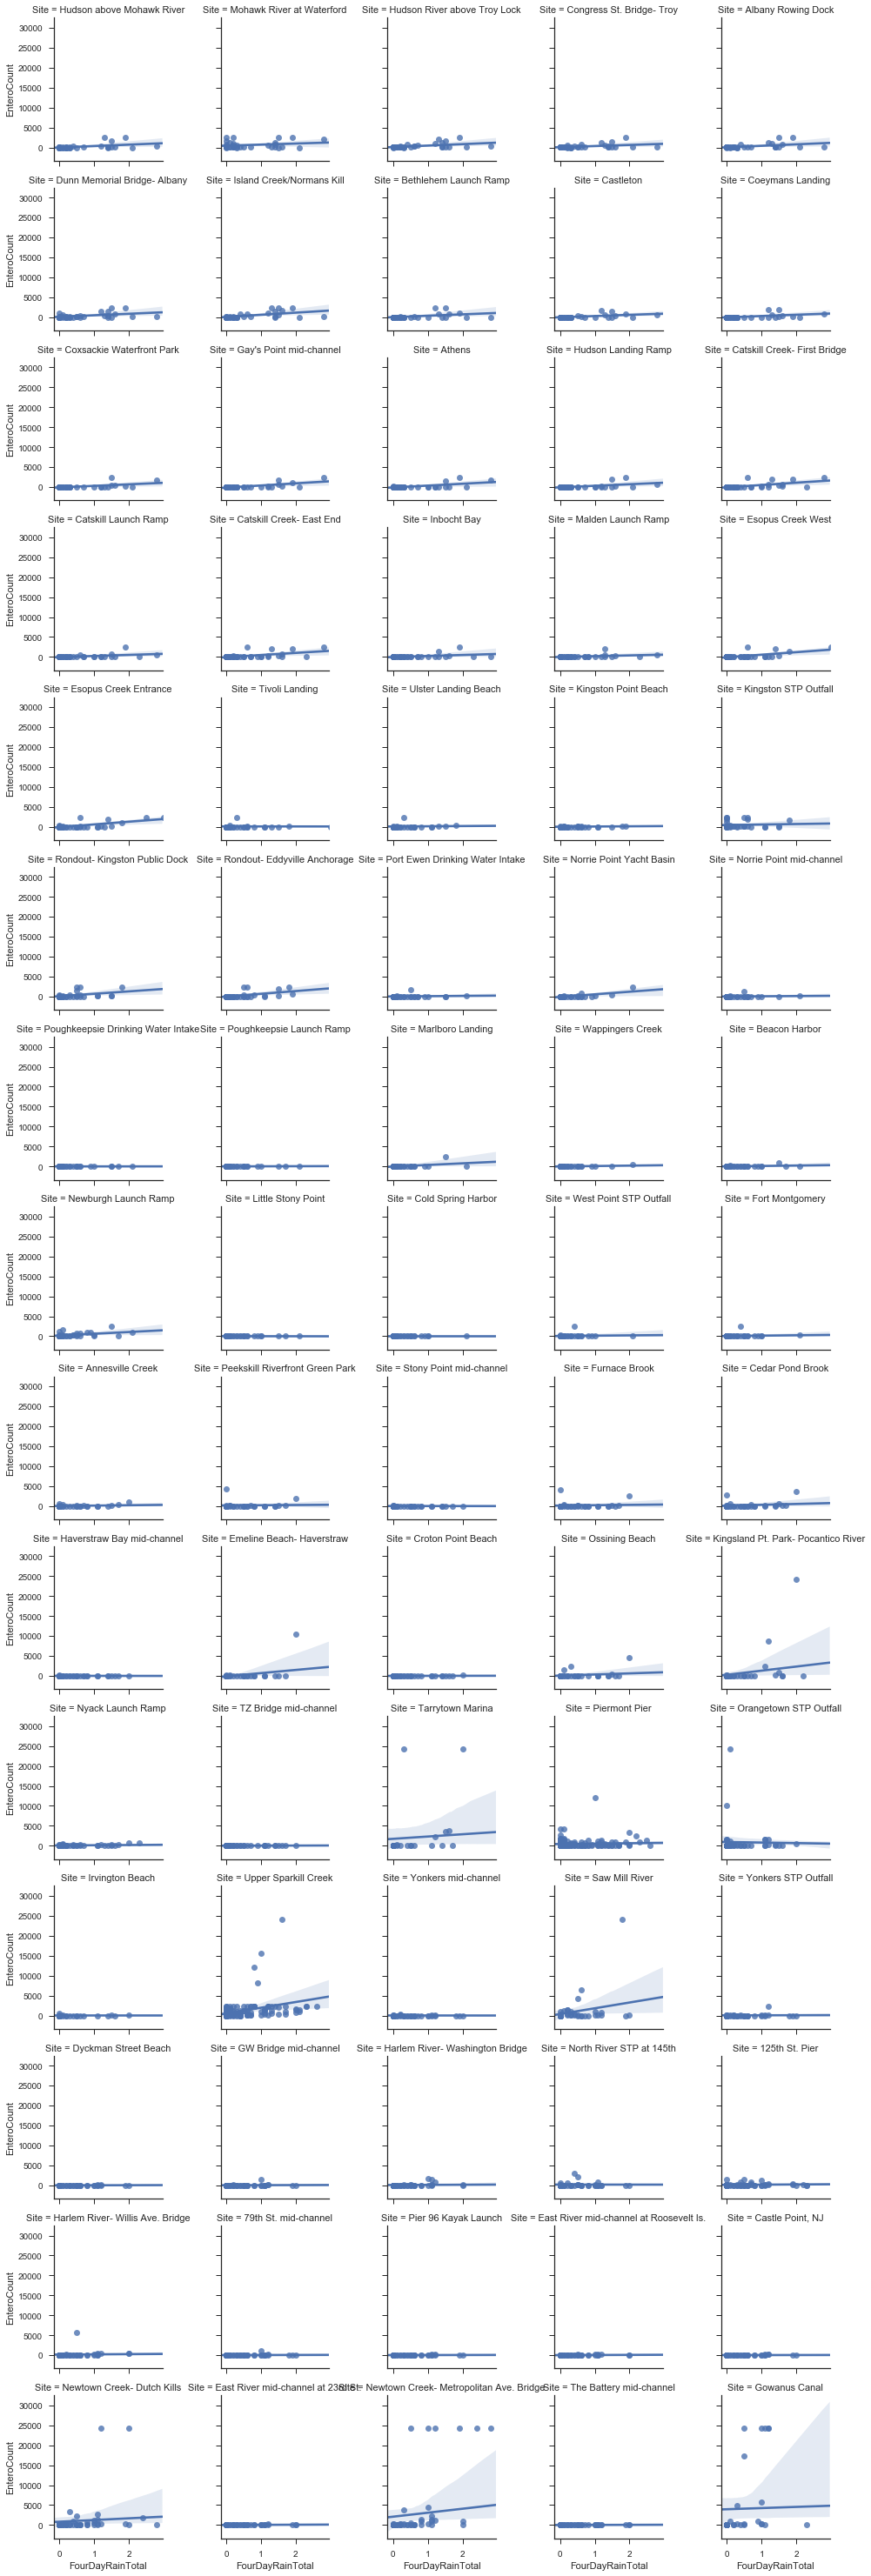

In [31]:
grid = sns.FacetGrid(df, col='Site', col_wrap=5, size=2.75)
grid = grid.map(sns.regplot, 'FourDayRainTotal', 'EnteroCount')

Scatter plots faceted by testing site as above, but with outlier EnteroCount and FourDayRainTotal observations (i.e., < 95th percentile for each variable) removed from dataset

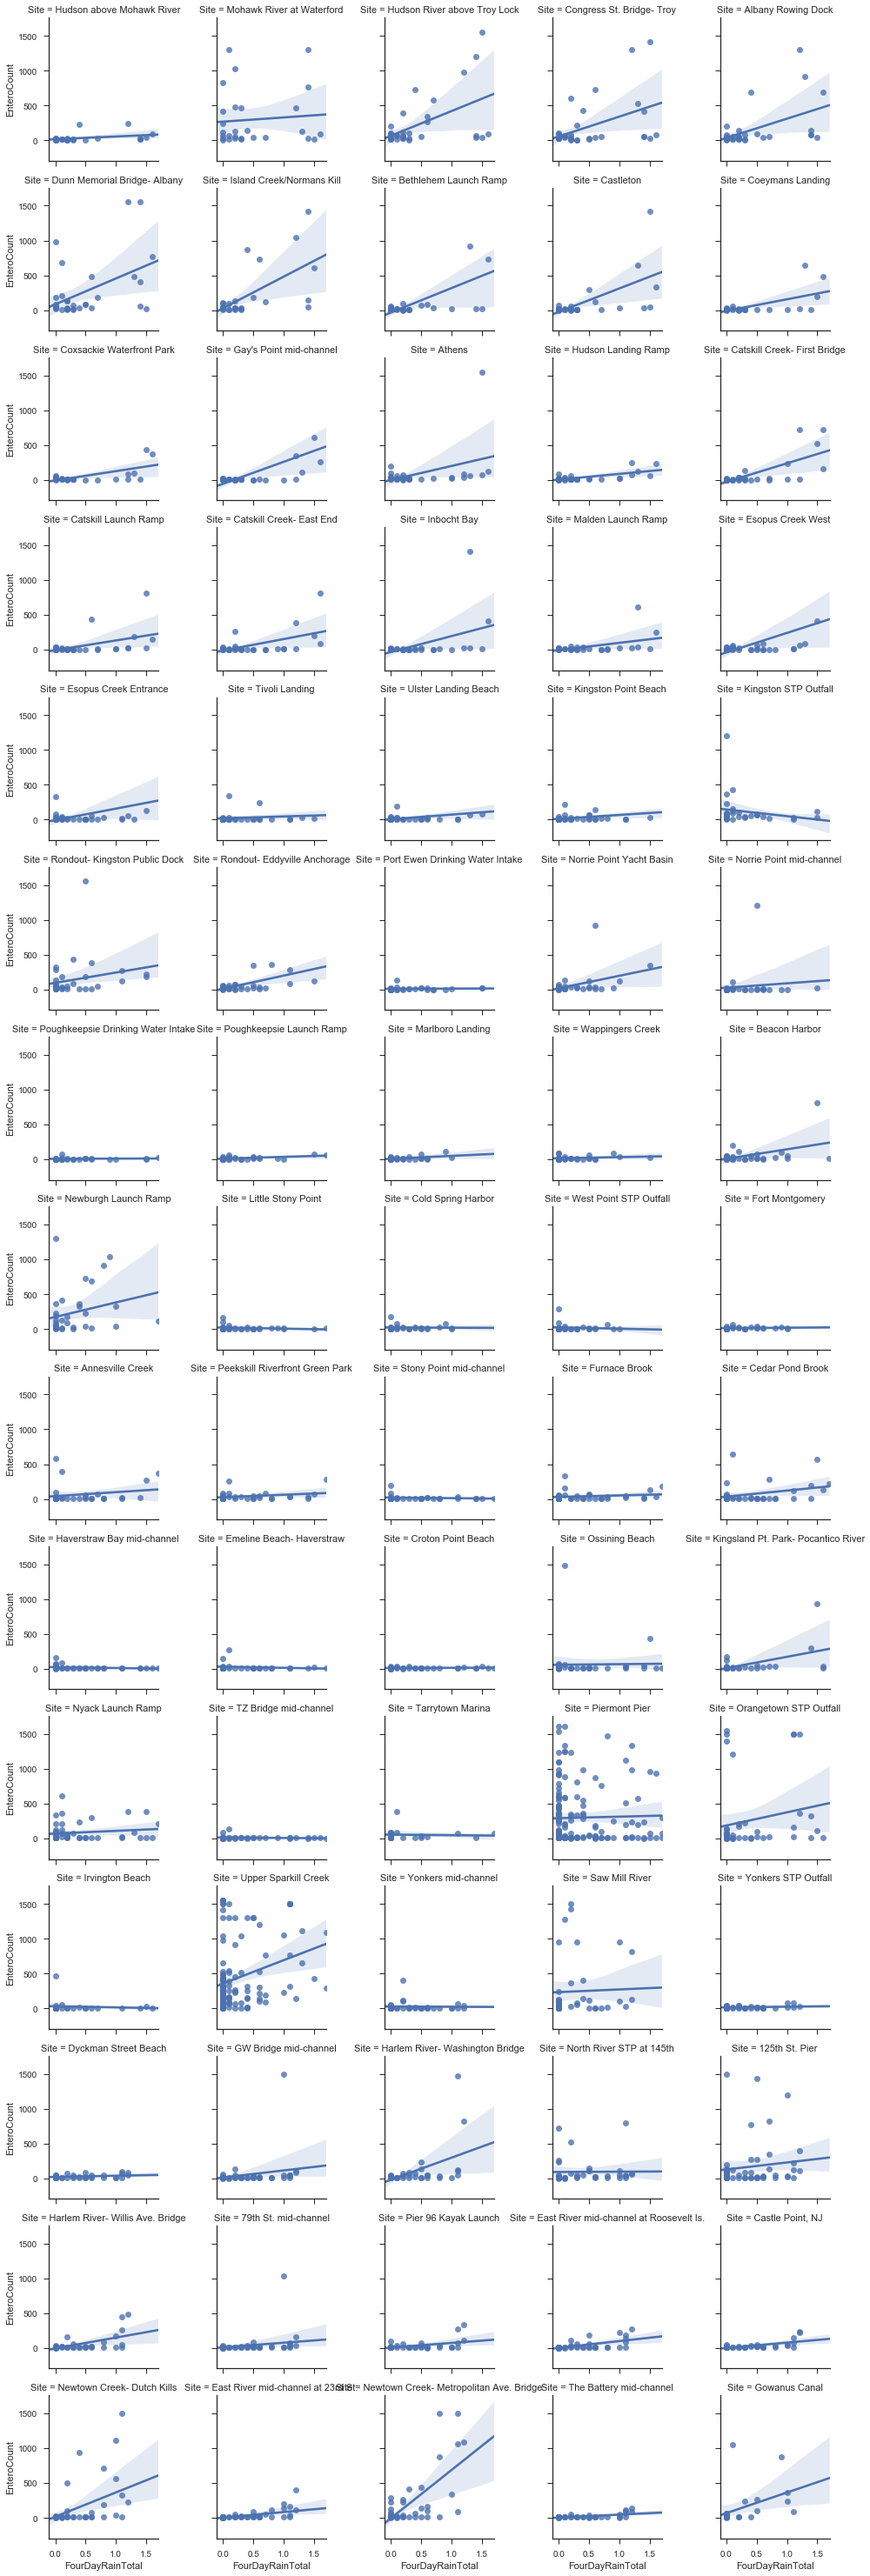

In [32]:
grid = sns.FacetGrid(new_df, col='Site', col_wrap=5, size=2.75)
grid = grid.map(sns.regplot, 'FourDayRainTotal', 'EnteroCount')

In [33]:
lm_stats = pd.DataFrame([])
for site in pd.unique(df['Site']):
    data = df.loc[df['Site'] == site]
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
        data['FourDayRainTotal'], data['EnteroCount']
    )
    row = {'site': site, 
           'slope': slope, 
           'intercept': intercept, 
           'r_value': r_value, 
           'p_value': p_value,
           'std_err': std_err}
    lm_stats = lm_stats.append(row, ignore_index=True)

Linear regression results for Enterococcus cell counts against four day rain totals by site, sorted by slope from highest to lowest

In [34]:
lm_stats[['site', 'slope', 'p_value', 'r_value']].sort_values(
    'slope', ascending=False).reset_index(drop=True)

,site,slope,p_value,r_value
0,Saw Mill River,1445.055347,6.168649e-04,0.467625
1,Upper Sparkill Creek,1427.831291,1.021330e-07,0.399996
2,Kingsland Pt. Park- Pocantico River,1030.706788,8.731242e-02,0.267064
3,Newtown Creek- Metropolitan Ave. Bridge,996.795895,1.325056e-01,0.201663
4,Emeline Beach- Haverstraw,793.270647,3.561190e-02,0.341952
5,Rondout- Eddyville Anchorage,688.379791,1.578204e-04,0.534063
6,Esopus Creek Entrance,676.086947,2.551704e-07,0.693362
7,Norrie Point Yacht Basin,648.289285,7.899452e-07,0.718810
8,Esopus Creek West,635.192924,2.581007e-06,0.654496
9,Rondout- Kingston Public Dock,603.106186,6.179535e-03,0.430843


As above but with regression models fit to data from each site with outlier EnteroCount and FourDayRainTotal observations (i.e., < 95th percentile for each variable across entire dataset) removed

In [35]:
lm_stats = pd.DataFrame([])
for site in pd.unique(df['Site']):
    data = new_df.loc[df['Site'] == site]
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(
        data['FourDayRainTotal'], data['EnteroCount']
    )
    row = {'site': site, 
           'slope': slope, 
           'intercept': intercept, 
           'r_value': r_value, 
           'p_value': p_value,
           'std_err': std_err}
    lm_stats = lm_stats.append(row, ignore_index=True)
    
lm_stats[['site', 'slope', 'p_value', 'r_value']].sort_values(
    'slope', ascending=False).reset_index(drop=True)

,site,slope,p_value,r_value
0,Newtown Creek- Metropolitan Ave. Bridge,692.117570,7.374471e-07,0.673692
1,Island Creek/Normans Kill,452.272999,3.130496e-04,0.622271
2,Dunn Memorial Bridge- Albany,370.767083,4.241028e-03,0.478071
3,Hudson River above Troy Lock,354.002160,1.966087e-03,0.519082
4,Bethlehem Launch Ramp,350.893497,4.389300e-06,0.714362
5,Newtown Creek- Dutch Kills,348.502767,5.412006e-04,0.490363
6,Castleton,336.834496,4.026821e-05,0.659550
7,Upper Sparkill Creek,335.219456,1.396602e-03,0.285025
8,Harlem River- Washington Bridge,316.737432,1.224828e-03,0.487526
9,Gay's Point mid-channel,314.306683,1.715265e-06,0.726265


There is a statistically significant positive association between rain fall totals in the last four days and the quantity of Enterococcus cells in tested samples at most sites in the dataset.